In [75]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
import os

import numpy as np

from keras.models import load_model

import cv2

import pandas as pd

import time

import pickle

from keras import backend as K

import tensorflow as tf



In [0]:
import sys
root_path = '/content/gdrive/My Drive/Kaggle/TGS-Salt-Segmentation/'
sys.path.append(root_path)

threshhold = 0.55
model_path = '/content/gdrive/My Drive/Kaggle/TGS-Salt-Segmentation/models/trained/(1)unet_101_binary_crossentropy_adam_accuracy.h5'
model_input_size = 101 if '101' in model_path else 128

data_path = '/content/drive/My Drive/Kaggle/TGS-Salt-Segmentation/data/'
test_img_path = data_path + 'test/x_test.npy'
valid_img_path = '/content/drive/My Drive/Kaggle/TGS-Salt-Segmentation/data/{}/all_samples/'.format(model_input_size)
submission_path = '/content/drive/My Drive/Kaggle/TGS-Salt-Segmentation/submissions/'+ model_path.split('/')[-1][:-3] + '-{:.2f}.csv'.format(threshhold)

need_resize = model_input_size != 101

In [0]:
with open('/content/drive/My Drive/Kaggle/TGS-Salt-Segmentation/data/test/test_img_ids.list', 'rb') as infile:
  test_img_ids = pickle.load(infile)

In [0]:
x_valid[i].shape

(128, 128, 1)

In [0]:
def iou(y_true, y_pred):
    import numpy as np     # linear algebra library
    import pandas as pd    
    import tensorflow as tf
    from random import randint
    from keras import backend as K
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
model = load_model(model_path, custom_objects={'iou':iou})

W0816 06:38:10.859394 139937357088640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0816 06:38:10.932804 139937357088640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0816 06:38:10.992810 139937357088640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 06:38:10.995397 139937357088640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 06:38:11.006054 139937357

In [0]:
def iou_np(mask, predict):
    intersection = np.logical_and(mask, predict).astype(int)
    union = np.logical_or(mask, predict).astype(int)
    intersec_sum = np.sum(intersection)
    union_sum = np.sum(union)
    return 0 if union_sum == 0 else intersec_sum/union_sum

In [0]:
def rle_encode(im):
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     print(runs, runs[1::2])
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



In [0]:
def predict(img):
    if need_resize:
        img = cv2.resize(img, (model_input_size , model_input_size), interpolation=cv2.INTER_CUBIC)
    img = img.reshape((1, model_input_size, model_input_size, 1))
    prediction = model.predict(img).reshape((model_input_size, model_input_size, 1))
#     
    prediction = (prediction > threshhold).astype(float)
    if need_resize:
        prediction = cv2.resize(prediction, (101,101), interpolation=cv2.INTER_AREA)
        prediction = prediction >= 0.99
    return prediction

In [0]:
x_test = np.load(test_img_path)

0.541629328920079

In [0]:
rle_masks = []
maxcnt = 10
start = time.time()


for i in range(x_test.shape[0]):
    if i%200 == 0 and i!=0:
        print('{}, {}s'.format(i, time.time() - start))
        start = time.time()
    img = x_test[i]
    prediction = predict(img, threshhold)
#     prediction = predict(img, 0.74)
    rle_masks.append(rle_encode(prediction))

print('finished 0.89')
submission = {'id':test_img_ids, 'rle_mask':rle_masks}

submission_df = pd.DataFrame.from_dict(submission)
submission_df.to_csv(submission_path, index=0)

In [0]:
x_valid = np.load(valid_img_path + 'x_valid.npy')
y_valid = np.load(valid_img_path + 'y_valid.npy')

OSError: ignored

In [0]:
import matplotlib.image as matimg
import matplotlib.pyplot as plt

def display_img_mask(x,img_ids:list, cols=4, mask=None, y=None):
    rows = int(np.ceil(len(img_ids)/cols))
    if len(img_ids) < cols:
        cols = len(img_ids)
    fig, ax = plt.subplots(rows,cols, figsize=(15, 30), squeeze=False)
    row_cnt = 0
    for i, img_id in enumerate(img_ids):
        row_cnt = row_cnt+1 if (i!=0 and i%cols==0) else row_cnt
        col_cnt = i%cols
        current_ax = ax[row_cnt][col_cnt]
        
        img_ = x[img_id]
        mask_pred = predict(img_)
        
        img_ = img_.reshape((101,101))
        mask_pred = mask_pred.reshape((101,101))
        kernel = np.ones((5,5), np.uint8)

        mask_pred_dilate = cv2.morphologyEx(mask_pred, cv2.MORPH_CLOSE, kernel)
        mask_pred_dilate = cv2.morphologyEx(mask_pred_dilate, cv2.MORPH_OPEN, kernel)
        
        
        current_ax.imshow(img_, 'gray', interpolation='none')
        current_ax.imshow(mask_pred_dilate, 'gray', interpolation='none', alpha=0.5)
        if y is not None:
          mask_actual = y[i].reshape((101,101))
          current_ax.imshow(mask_actual, 'gray', interpolation='none', alpha=0.5)
        current_ax.imshow(mask_pred, 'seismic', interpolation='none', alpha=0.5)
        current_ax.set_title(img_id, fontsize=50)
 

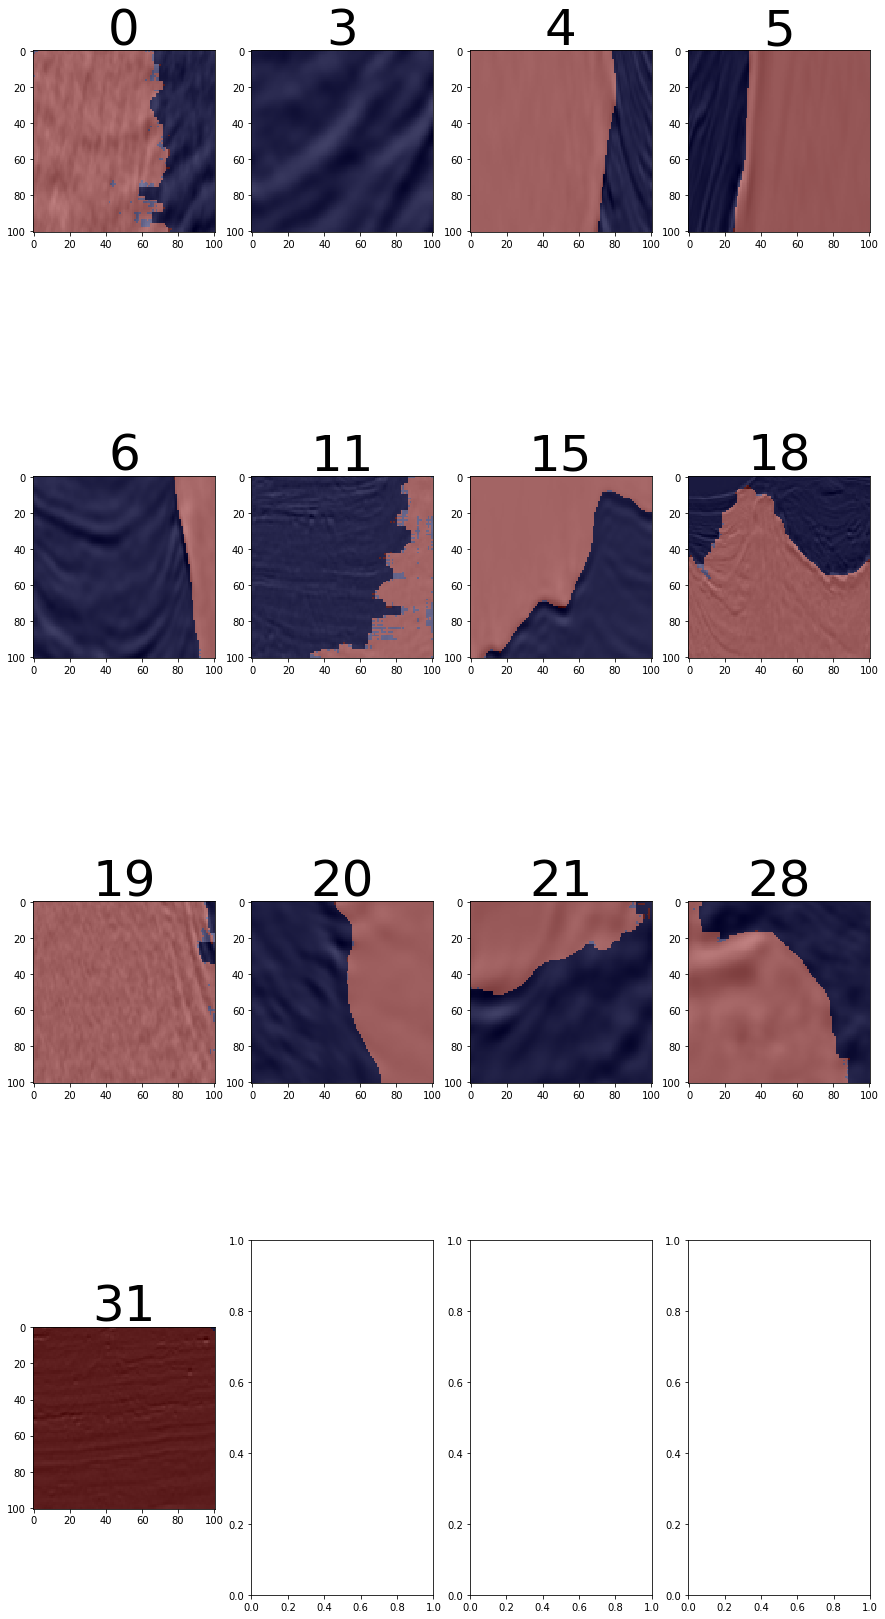

In [0]:
# display_img_mask(x_valid, np.random.randint(x_valid.shape[0], size=30), y=y_valid)
display_img_mask(x_test, sorted([0, 6, 4,5,3,11,19,18,21,15,20,31,28]))

In [0]:
# find best threshhod
thresh_iou = {}
for thresh in np.arange(0.50, 1.0, 0.05):
    avg_iou = 0
    for i, img in enumerate(range(x_valid.shape[0])):
        prediction = model.predict(x_valid[i].reshape(1, 101, 101, 1))
        avg_iou += iou_np((prediction > thresh).astype(int), y_valid[i])
    
    avg_iou = avg_iou / x_valid.shape[0]
    thresh_iou[thresh] = avg_iou
    print(thresh_iou)

{0.5: 0.8104570775982842}
{0.5: 0.8104570775982842, 0.55: 0.810385642295273}
{0.5: 0.8104570775982842, 0.55: 0.810385642295273, 0.6000000000000001: 0.8103384158592518}
{0.5: 0.8104570775982842, 0.55: 0.810385642295273, 0.6000000000000001: 0.8103384158592518, 0.6500000000000001: 0.8103322480482069}
{0.5: 0.8104570775982842, 0.55: 0.810385642295273, 0.6000000000000001: 0.8103384158592518, 0.6500000000000001: 0.8103322480482069, 0.7000000000000002: 0.8102395006478982}
{0.5: 0.8104570775982842, 0.55: 0.810385642295273, 0.6000000000000001: 0.8103384158592518, 0.6500000000000001: 0.8103322480482069, 0.7000000000000002: 0.8102395006478982, 0.7500000000000002: 0.8100117173835332}
{0.5: 0.8104570775982842, 0.55: 0.810385642295273, 0.6000000000000001: 0.8103384158592518, 0.6500000000000001: 0.8103322480482069, 0.7000000000000002: 0.8102395006478982, 0.7500000000000002: 0.8100117173835332, 0.8000000000000003: 0.8098709342295749}
{0.5: 0.8104570775982842, 0.55: 0.810385642295273, 0.600000000000000